In [ ]:
pip install numpy pandas matplotlib pyts tensorflow scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


train_df = pd.read_csv("trainDataset.csv")
test_df = pd.read_csv("testDataset.csv")


columns_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']



In [ ]:

def preprocess_and_convert_gaf(df, window_size=20):
    data_series = df[columns_to_use].values

    min_vals = np.min(data_series, axis=0)
    max_vals = np.max(data_series, axis=0)
    data_series = 2 * (data_series - min_vals) / (max_vals - min_vals) - 1

    X = np.array([data_series[i : i + window_size] for i in range(len(data_series) - window_size)])
    y = df['Pattern'][window_size:].values

    gaf = GramianAngularField(method='summation')
    X_gaf_channels = [gaf.fit_transform(X[:, :, i]) for i in range(X.shape[2])]

    X_gaf_multichannel = np.stack(X_gaf_channels, axis=-1)

    return X_gaf_multichannel, y


window_size = 20
X_train, y_train = preprocess_and_convert_gaf(train_df, window_size)
X_test, y_test = preprocess_and_convert_gaf(test_df, window_size)



In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (58487, 20, 20, 5)
Shape of y_train: (58487,)
Shape of X_test: (14247, 20, 20, 5)
Shape of y_test: (14247,)


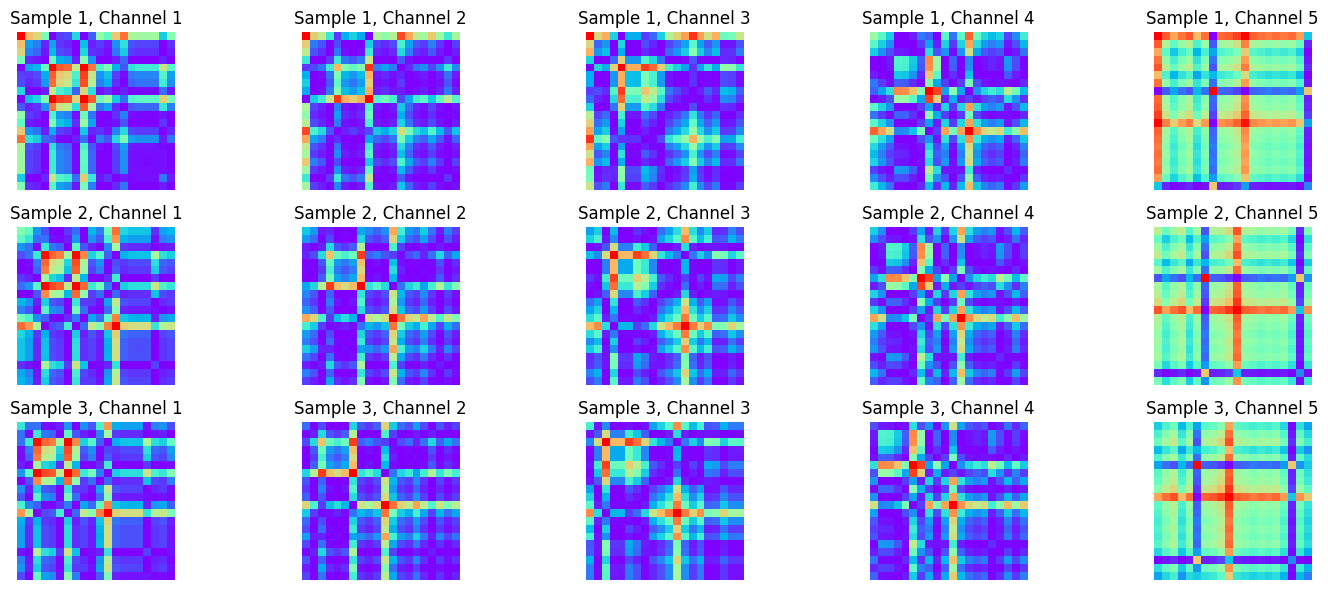

In [ ]:
num_images = 3
num_channels = X_train.shape[-1]

fig, axes = plt.subplots(num_images, num_channels, figsize=(15, 6))

for i in range(num_images):
    for j in range(num_channels):
        axes[i, j].imshow(X_train[i][:, :, j], cmap='rainbow')  # Plot each channel separately
        axes[i, j].set_title(f"Sample {i+1}, Channel {j+1}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:



model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(window_size, window_size, len(columns_to_use))),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(set(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy with Multi-Channel GAF: {test_acc:.4f}")


Epoch 1/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 170s 92ms/step - accuracy: 0.2226 - loss: 2.1003 - val_accuracy: 0.2600 - val_loss: 1.8847 - learning_rate: 0.0010
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 199s 90ms/step - accuracy: 0.2848 - loss: 1.8297 - val_accuracy: 0.2770 - val_loss: 1.8280 - learning_rate: 0.0010
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 201s 90ms/step - accuracy: 0.3170 - loss: 1.7570 - val_accuracy: 0.3024 - val_loss: 1.8017 - learning_rate: 0.0010
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 202s 90ms/step - accuracy: 0.3528 - loss: 1.6744 - val_accuracy: 0.3168 - val_loss: 1.8420 - learning_rate: 0.0010
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 200s 88ms/step - accuracy: 0.3883 - loss: 1.5849 - val_accuracy: 0.3334 - val_loss: 1.8244 - learning_rate: 0.0010
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 165s 90ms/step - accuracy: 0.4249 - loss: 1.4937 - val_accuracy: 0.3292 - val_loss: 1.8362 - learning_rate: 0.0010
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 199s 89ms/step -